In [1]:
%cd ../..

/home/dmoreno/ATAT_ZTF/elasticc_one


# Confusion matrices

In [2]:
import os
import json 
import torch

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

#from utils import get_y_test_pred_folds, get_confusion_matrix

/home/dmoreno/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
path_data = './data/final/ZTF_ff/LC_MD_FEAT_v2_windows'
path_results = './results/ZTF/LC_MD_FEAT/prueba_lc_md_feat_mta_v2_windows/MTA'
time_to_eval = 2048

order_classes = ['SNIa', # yes
                 'SNIbc', # yes
                 'SNIIb', # yes
                 'SNII', # yes
                 'SNIIn', # yes
                 'SLSN', # yes
                 'TDE', # yes
                 'Microlensing', # yes
                 'QSO', 
                 'AGN', # yes
                 'Blazar', 
                 'YSO', 
                 'CV/Nova', 
                 'LPV', 
                 'EA', 
                 'EB/EW', # yes
                 'Periodic-Other', 
                 'RSCVn', 
                 'CEP', 
                 'RRLab', 
                 'RRLc', 
                 'DSCT']

In [5]:
import yaml

def load_yaml(path):
    with open(path, 'r') as file:
        args = yaml.load(file, Loader=yaml.FullLoader)
    return args

dict_info = load_yaml('{}/dict_info.yaml'.format(path_data))

mapping_classes = dict_info['mapping_classes']
mapping_classes_inverted = {v: k for k, v in mapping_classes.items()}
print(mapping_classes_inverted)

{5: 'AGN', 15: 'Blazar', 11: 'CEP', 14: 'CV/Nova', 1: 'DSCT', 12: 'EA', 2: 'EB/EW', 7: 'LPV', 21: 'Microlensing', 13: 'Periodic-Other', 3: 'QSO', 10: 'RRLab', 8: 'RRLc', 4: 'RSCVn', 18: 'SLSN', 19: 'SNII', 16: 'SNIIb', 0: 'SNIIn', 6: 'SNIa', 20: 'SNIbc', 17: 'TDE', 9: 'YSO'}


In [24]:
predictions = torch.load('{}/all_predictions_times.pt'.format(path_results))
predictions

{'SNID': array([b'ZTF17aaaecgi_0', b'ZTF17aaaecgi_1', b'ZTF17aaaecgi_2', ...,
        b'ZTF23abcvqkd_3', b'ZTF23abcvqkd_4', b'ZTF23abcvqkd_5'],
       dtype=object),
 'y_test': tensor([2, 2, 2,  ..., 6, 6, 6]),
 'list_y_pred': {'test_16': array([12,  2,  2, ..., 19, 19, 19]),
  'test_32': array([ 2,  2,  2, ..., 19, 16,  6]),
  'test_64': array([ 2,  2,  2, ..., 19, 19,  6]),
  'test_128': array([ 2,  2,  2, ..., 19, 19,  6]),
  'test_256': array([ 2,  2,  2, ..., 19, 19,  6]),
  'test_512': array([ 2,  2,  2, ..., 19,  6,  6]),
  'test_1024': array([ 2,  2,  2, ..., 19,  6,  6]),
  'test_2048': array([2, 2, 2, ..., 6, 6, 6])},
 'list_y_pred_prob': {'test_16': array([[6.6730954e-11, 1.0940837e-03, 3.1876701e-01, ..., 4.3237228e-10,
          6.9853623e-10, 1.2553594e-11],
         [1.1172583e-10, 7.6153030e-04, 6.7463577e-01, ..., 9.0121979e-11,
          3.1843755e-10, 5.5606761e-12],
         [3.4219034e-11, 2.4041331e-03, 7.4660689e-01, ..., 4.0153336e-11,
          3.3124371e-11, 4

In [25]:
# Procesamiento para agregar los índices correspondientes
from itertools import groupby

# Convertir bytes a str para facilitar la manipulación
snids_str = [snid.decode("utf-8") for snid in predictions['SNID']]

# Función para extraer el identificador base de cada SNID
def base_id(snid):
    return "_".join(snid.split("_")[:-1])

# Agrupar por el identificador base
grouped = groupby(range(len(snids_str)), key=lambda x: base_id(snids_str[x]))

# Crear la nueva clave con los índices agrupados
idx_windows_objects = [list(group) for _, group in grouped]

# Crear la clave 'idx_unique_y_test' con los índices del SNID 0 de todos los objetos
idx_unique_y_test = []
ids_unique = []

for i, snid in enumerate(snids_str):
    if snid.endswith("_0"):
        idx_unique_y_test.append(i)
        ids_unique.append('aid_{}'.format(snid.split('_')[0]))

# Mostrar el resultado
print('length: ', len(idx_windows_objects))
print(idx_windows_objects)
print('length: ', len(idx_unique_y_test))
print(idx_unique_y_test)

length:  41747
[[0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], [16, 17, 18, 19, 20], [21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37], [38, 39, 40, 41, 42, 43, 44, 45], [46, 47, 48, 49, 50, 51, 52, 53], [54, 55, 56], [57, 58, 59, 60, 61], [62, 63, 64, 65, 66], [67, 68, 69, 70, 71, 72, 73], [74, 75, 76, 77, 78, 79], [80, 81, 82, 83], [84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], [96, 97, 98, 99, 100], [101, 102, 103, 104, 105], [106, 107, 108, 109, 110, 111, 112], [113, 114, 115, 116, 117, 118], [119, 120, 121, 122, 123], [124, 125, 126, 127], [128, 129, 130, 131], [132, 133, 134, 135, 136, 137, 138], [139, 140, 141, 142, 143], [144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154], [155, 156, 157, 158, 159, 160, 161, 162, 163], [164, 165, 166, 167], [168, 169, 170, 171, 172, 173, 174, 175, 176], [177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188], [189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199], [200, 201, 202, 203, 204, 205, 206, 

In [26]:
print(ids_unique)
print(len(ids_unique))

['aid_ZTF17aaaecgi', 'aid_ZTF17aaaedvi', 'aid_ZTF17aaafglk', 'aid_ZTF17aaafiut', 'aid_ZTF17aaafiww', 'aid_ZTF17aaafyis', 'aid_ZTF17aaafyxs', 'aid_ZTF17aaagryq', 'aid_ZTF17aaaidzt', 'aid_ZTF17aaaizfv', 'aid_ZTF17aaakbvl', 'aid_ZTF17aaaorgv', 'aid_ZTF17aaaowhs', 'aid_ZTF17aaaqtul', 'aid_ZTF17aaarxab', 'aid_ZTF17aaarxbz', 'aid_ZTF17aaarzye', 'aid_ZTF17aaasboc', 'aid_ZTF17aaasklh', 'aid_ZTF17aaatgma', 'aid_ZTF17aaatkxt', 'aid_ZTF17aaatlhi', 'aid_ZTF17aaauijj', 'aid_ZTF17aaaweng', 'aid_ZTF17aaawqzp', 'aid_ZTF17aabhlnm', 'aid_ZTF17aabooqt', 'aid_ZTF17aabootn', 'aid_ZTF17aabopzp', 'aid_ZTF17aaboqfs', 'aid_ZTF17aabppsz', 'aid_ZTF17aabppwh', 'aid_ZTF17aabqidu', 'aid_ZTF17aabummz', 'aid_ZTF17aabupde', 'aid_ZTF17aabuphg', 'aid_ZTF17aabuuyx', 'aid_ZTF17aabuvjm', 'aid_ZTF17aabvgfc', 'aid_ZTF17aabviic', 'aid_ZTF17aabxamk', 'aid_ZTF17aabxkhe', 'aid_ZTF17aacgwpq', 'aid_ZTF17aackses', 'aid_ZTF17aactvce', 'aid_ZTF17aadgwyo', 'aid_ZTF17aadidmw', 'aid_ZTF17aadjkhd', 'aid_ZTF17aadooax', 'aid_ZTF18aaaajiw',

In [27]:
# Calcular el promedio de las probabilidades para cada conjunto de ventanas

predictions.update({
    'list_y_pred_prob_avg': dict(),
    'list_y_pred_avg': dict(),
    })

for eval_time, predicciones in predictions['list_y_pred_prob'].items():
    predictions['list_y_pred_prob_avg'][eval_time] = [] 
    predictions['list_y_pred_avg'][eval_time] = [] 
    for idx_windows in idx_windows_objects:
        window_probs = predicciones[idx_windows]
        avg_probs = np.mean(window_probs, axis=0)
        predictions['list_y_pred_prob_avg'][eval_time].append(avg_probs)
        predictions['list_y_pred_avg'][eval_time].append(np.argmax(avg_probs, axis=0))

    predictions['list_y_pred_prob_avg'][eval_time] = np.array(predictions['list_y_pred_prob_avg'][eval_time])
    predictions['list_y_pred_avg'][eval_time] = np.array(predictions['list_y_pred_avg'][eval_time])

predictions['list_y_pred_avg']

{'test_16': array([ 2,  7, 14, ...,  6,  6, 19]),
 'test_32': array([ 2,  7, 14, ...,  0,  6, 19]),
 'test_64': array([ 2,  7, 14, ...,  0,  6, 19]),
 'test_128': array([ 2,  7, 14, ...,  0,  6, 19]),
 'test_256': array([ 2,  7, 14, ...,  0,  6, 19]),
 'test_512': array([ 2,  7, 14, ...,  0,  6, 19]),
 'test_1024': array([ 2,  7, 14, ...,  0,  6, 19]),
 'test_2048': array([ 2,  7, 14, ...,  0,  6,  6])}

In [28]:
predictions['y_test_unique'] = predictions['y_test'][idx_unique_y_test]
predictions['y_test_unique'].shape

torch.Size([41747])

In [29]:
predictions['SNID']

array([b'ZTF17aaaecgi_0', b'ZTF17aaaecgi_1', b'ZTF17aaaecgi_2', ...,
       b'ZTF23abcvqkd_3', b'ZTF23abcvqkd_4', b'ZTF23abcvqkd_5'],
      dtype=object)

In [30]:
predictions.keys()

dict_keys(['SNID', 'y_test', 'list_y_pred', 'list_y_pred_prob', 'list_y_pred_prob_avg', 'list_y_pred_avg', 'y_test_unique'])

In [31]:
import pandas as pd

def sort_dict_by_value(d, reverse=False):
    return dict(sorted(d.items(), key=lambda x: x[1], reverse=reverse))

mlp_predictions = pd.read_parquet('results/ZTF/Others_models/all_predictions.parquet')
brf_predictions = pd.read_parquet('results/ZTF/Others_models/rf_predictions.parquet')

In [32]:
mlp_predictions[mlp_predictions['shorten'] == 'None'].head()

AGN        Blazar       CEP   CV/Nova      DSCT   
aid_ZTF17aaaazva  3.273147e-07  8.899890e-07  0.946160  0.000155  0.000022  \
aid_ZTF17aaaeayj  2.204705e-06  1.668178e-04  0.092140  0.005643  0.000012   
aid_ZTF17aaafynz  2.046014e-10  4.948780e-10  0.000140  0.000025  0.000118   
aid_ZTF17aaagrkx  5.473671e-11  9.899291e-12  0.000049  0.000005  0.000978   
aid_ZTF17aaagvif  1.129457e-05  2.233477e-04  0.002201  0.005982  0.000083   

                        EA     EB/EW           LPV  Microlensing   
aid_ZTF17aaaazva  0.003662  0.002076  2.440616e-04  8.240604e-07  \
aid_ZTF17aaaeayj  0.003964  0.001446  1.837340e-03  5.894973e-08   
aid_ZTF17aaafynz  0.062848  0.933578  2.264811e-08  2.514657e-11   
aid_ZTF17aaagrkx  0.044501  0.953254  4.401320e-09  4.064046e-13   
aid_ZTF17aaagvif  0.003301  0.001326  9.053756e-04  6.217704e-11   

                  Periodic-Other  ...     RSCVn          SLSN          SNII   
aid_ZTF17aaaazva        0.000575  ...  0.014825  5.650460e-11  2.095842e-08  \
aid_ZTF17aaaeayj        0.002703  ...  0.004267  8.032051e-11  1.887207e-08   
aid_ZTF17aaafynz        0.000357  ...  0.000022  5.722317e-14  5.721857e-11   
aid_ZTF17aaagrkx        0.000503  ...  0.000129  1.443173e-15  2.722558e-11   
aid_ZTF17aaagvif        0.002768  ...  0.016292  2.053907e-12  9.555637e-09   

                         SNIIb         SNIIn          SNIa         SNIbc   
aid_ZTF17aaaazva  2.841476e-13  3.917263e-10  1.421470e-07  3.452122e-10  \
aid_ZTF17aaaeayj  1.063153e-14  6.413310e-09  8.715928e-08  4.442233e-10   
aid_ZTF17aaafynz  1.273456e-17  7.581815e-12  3.487710e-10  2.410845e-13   
aid_ZTF17aaagrkx  1.029981e-16  4.324150e-13  4.202426e-10  3.722774e-14   
aid_ZTF17aaagvif  7.773609e-14  2.543183e-08  8.376813e-08  1.960493e-10   

                           TDE           YSO  shorten  
aid_ZTF17aaaazva  8.829396e-12  6.476458e-03     None  
aid_ZTF17aaaeayj  1.917565e-13  8.870033e-01     None  
aid_ZTF17aaafynz  3.046645e-14  1.806964e-06     None  
aid_ZTF17aaagrkx  1.899844e-14  6.980965e-07     None  
aid_ZTF17aaagvif  4.136030e-13  9.668869e-01     None  

[5 rows x 23 columns]

In [33]:
brf_predictions[brf_predictions['shorten'] == 'None'].head()

AGN  Blazar    CEP  CV/Nova   DSCT     EA  EB/EW    LPV   
aid_ZTF17aaaazva  0.010   0.020  0.536    0.002  0.004  0.052  0.038  0.034  \
aid_ZTF17aaaeayj  0.004   0.018  0.174    0.016  0.000  0.010  0.000  0.058   
aid_ZTF17aaafynz  0.000   0.000  0.026    0.004  0.008  0.058  0.796  0.000   
aid_ZTF17aaagrkx  0.000   0.000  0.004    0.000  0.012  0.036  0.924  0.000   
aid_ZTF17aaagvif  0.022   0.080  0.072    0.032  0.010  0.082  0.036  0.054   

                  Microlensing  Periodic-Other  ...  RSCVn  SLSN   SNII   
aid_ZTF17aaaazva         0.010           0.056  ...  0.100   0.0  0.000  \
aid_ZTF17aaaeayj         0.002           0.012  ...  0.024   0.0  0.000   
aid_ZTF17aaafynz         0.002           0.042  ...  0.014   0.0  0.000   
aid_ZTF17aaagrkx         0.000           0.010  ...  0.002   0.0  0.000   
aid_ZTF17aaagvif         0.008           0.016  ...  0.034   0.0  0.006   

                  SNIIb  SNIIn   SNIa  SNIbc    TDE    YSO  shorten  
aid_ZTF17aaaazva  0.002    0.0  0.000    0.0  0.004  0.104     None  
aid_ZTF17aaaeayj  0.002    0.0  0.000    0.0  0.000  0.672     None  
aid_ZTF17aaafynz  0.000    0.0  0.000    0.0  0.000  0.004     None  
aid_ZTF17aaagrkx  0.000    0.0  0.000    0.0  0.000  0.000     None  
aid_ZTF17aaagvif  0.004    0.0  0.004    0.0  0.004  0.506     None  

[5 rows x 23 columns]

In [34]:
sort_classes = list(sort_dict_by_value(mapping_classes).keys())
print(sort_classes)

['SNIIn', 'DSCT', 'EB/EW', 'QSO', 'RSCVn', 'AGN', 'SNIa', 'LPV', 'RRLc', 'YSO', 'RRLab', 'CEP', 'EA', 'Periodic-Other', 'CV/Nova', 'Blazar', 'SNIIb', 'TDE', 'SLSN', 'SNII', 'SNIbc', 'Microlensing']


In [35]:
list_times_to_eval = brf_predictions['shorten'].unique()
list_times_to_eval

array(['1024', '128', '16', '256', '32', '512', '64', 'None'],
      dtype=object)

In [36]:
dict_mlp_predictions = dict({
    'list_y_pred': dict(),
    'list_y_pred_prob': dict(),
    })
dict_brf_predictions = dict({
    'list_y_pred': dict(),
    'list_y_pred_prob': dict(),
    })

for time_to_eval in list_times_to_eval:
    mlp_pred_x_time = mlp_predictions[mlp_predictions['shorten'] == time_to_eval]
    mlp_pred_x_time = mlp_pred_x_time.reindex(ids_unique)[sort_classes]

    brf_pred_x_time = brf_predictions[brf_predictions['shorten'] == time_to_eval]
    brf_pred_x_time = brf_pred_x_time.reindex(ids_unique)[sort_classes]

    if time_to_eval == 'None':
        dict_mlp_predictions['list_y_pred_prob']['test_2048'] = mlp_pred_x_time.values
        dict_mlp_predictions['list_y_pred']['test_2048'] = np.argmax(mlp_pred_x_time.values, axis=1)
        
        dict_brf_predictions['list_y_pred_prob']['test_2048'] = brf_pred_x_time.values
        dict_brf_predictions['list_y_pred']['test_2048'] = np.argmax(brf_pred_x_time.values, axis=1)

    else:
        dict_mlp_predictions['list_y_pred_prob']['test_{}'.format(time_to_eval)] = mlp_pred_x_time.values
        dict_mlp_predictions['list_y_pred']['test_{}'.format(time_to_eval)] = np.argmax(mlp_pred_x_time.values, axis=1)
        
        dict_brf_predictions['list_y_pred_prob']['test_{}'.format(time_to_eval)] = brf_pred_x_time.values
        dict_brf_predictions['list_y_pred']['test_{}'.format(time_to_eval)] = np.argmax(brf_pred_x_time.values, axis=1)


In [37]:
dict_mlp_predictions

{'list_y_pred': {'test_1024': array([ 2,  7, 14, ...,  0,  6, 20]),
  'test_128': array([ 2,  7, 14, ...,  0,  6, 20]),
  'test_16': array([ 2,  7, 14, ...,  0,  6, 20]),
  'test_256': array([ 2,  7, 14, ...,  0,  6, 20]),
  'test_32': array([ 2,  7, 14, ...,  0,  6, 20]),
  'test_512': array([ 2,  7, 14, ...,  0,  6, 20]),
  'test_64': array([ 2,  7, 14, ...,  0,  6, 20]),
  'test_2048': array([ 2,  7, 14, ...,  0,  6,  6])},
 'list_y_pred_prob': {'test_1024': array([[3.51684522e-14, 7.87547688e-05, 9.52066302e-01, ...,
          2.11884785e-12, 1.62616180e-15, 1.31652501e-14],
         [5.42477380e-07, 5.39221446e-06, 1.85039207e-05, ...,
          2.81196918e-07, 1.33593681e-09, 1.69068382e-09],
         [1.56285221e-10, 9.08906630e-04, 1.08639011e-04, ...,
          1.60234972e-08, 6.17946228e-08, 1.81818553e-11],
         ...,
         [9.89381313e-01, 1.65243662e-07, 3.90509825e-07, ...,
          1.79073517e-03, 2.41972870e-04, 1.45475998e-09],
         [1.27936233e-04, 1.608695

In [38]:
list(dict_mlp_predictions['list_y_pred_prob'].keys())

['test_1024',
 'test_128',
 'test_16',
 'test_256',
 'test_32',
 'test_512',
 'test_64',
 'test_2048']

In [39]:
predictions.keys()

dict_keys(['SNID', 'y_test', 'list_y_pred', 'list_y_pred_prob', 'list_y_pred_prob_avg', 'list_y_pred_avg', 'y_test_unique'])

In [40]:
dict_avg_pred_models = dict({
    'snids': ids_unique,
    'list_y_pred_prob_avg': dict(),
    'list_y_pred_avg': dict(),
    'y_test': predictions['y_test_unique'],
    })

In [41]:
dict_avg_pred_models['list_y_pred_prob_avg'][time_to_eval] = avg_probs
dict_avg_pred_models['list_y_pred_prob_avg'][time_to_eval]

array([1.67769686e-05, 3.60513432e-08, 3.00665732e-08, 1.36262386e-07,
       1.57970153e-08, 2.44860505e-08, 9.69419658e-01, 1.20986305e-08,
       9.22968102e-09, 2.05095336e-08, 1.18009687e-07, 2.15780660e-09,
       6.40416431e-09, 5.78444492e-08, 1.10997362e-02, 4.81838782e-08,
       2.27952245e-04, 2.04380501e-12, 4.08302015e-03, 1.41364262e-02,
       1.01600296e-03, 8.72553765e-11], dtype=float32)

In [42]:
time_to_eval

'None'

In [43]:
dict_avg_pred_models = dict({
    'snids': ids_unique,
    'list_y_pred_prob_avg': dict(),
    'list_y_pred_avg': dict(),
    'y_test': predictions['y_test_unique'],
    })

for time_to_eval in list(dict_mlp_predictions['list_y_pred_prob'].keys()):
    mlp_pred = dict_mlp_predictions['list_y_pred_prob'][time_to_eval]
    brf_pred = dict_brf_predictions['list_y_pred_prob'][time_to_eval]
    atat_pred = predictions['list_y_pred_prob_avg'][time_to_eval]

    list_preds = [mlp_pred, brf_pred, atat_pred]
    avg_probs = np.mean(list_preds, axis=0)

    dict_avg_pred_models['list_y_pred_prob_avg'][time_to_eval] = avg_probs
    dict_avg_pred_models['list_y_pred_avg'][time_to_eval] = np.argmax(avg_probs, axis=1)

In [44]:
avg_probs.shape

(41747, 22)

In [45]:
dict_avg_pred_models['list_y_pred_avg']['test_16']

array([ 2,  7, 14, ...,  0,  6, 20])

In [46]:
y_test_label = dict_avg_pred_models['y_test']
y_pred_label = dict_avg_pred_models['list_y_pred_avg']['test_2048']

y_test_label = [mapping_classes_inverted[x] for x in y_test_label.numpy()]
y_pred_label = [mapping_classes_inverted[x] for x in y_pred_label]

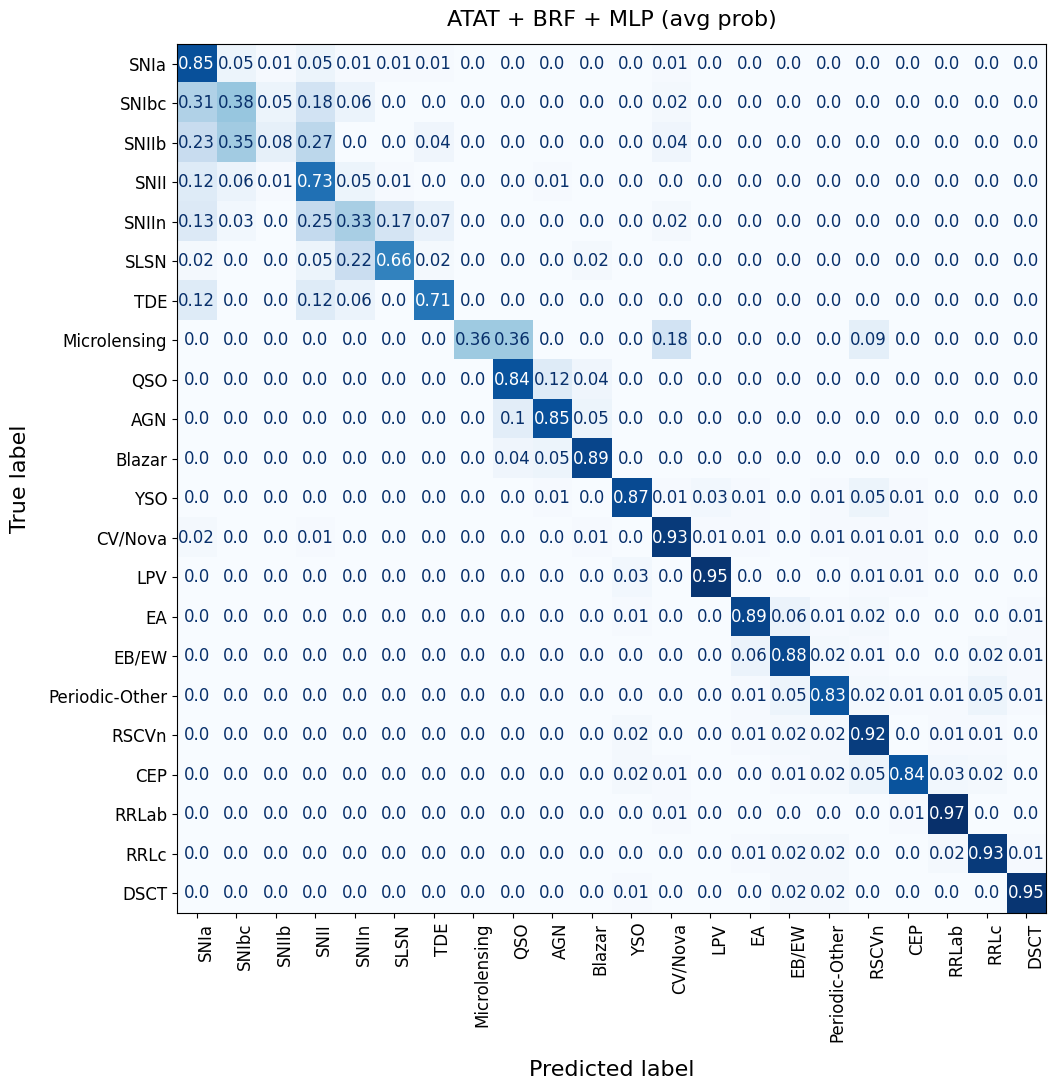

In [342]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

fs = 12

cm = confusion_matrix(y_true=y_test_label, y_pred=y_pred_label, labels=order_classes, normalize='true')

cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(11, 11)) #, dpi=110)
im = ax.imshow(np.around(cm, decimals=2), interpolation='nearest', cmap=cmap)

# color map
new_color = cmap(1.0) 

# Añadiendo manualmente las anotaciones con la media y desviación estándar
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] >= 0.005:
            #print(cm[i, j])
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)
        else:
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)

# Ajustes finales y mostrar la gráfica
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(np.arange(len(order_classes)))
ax.set_yticks(np.arange(len(order_classes)))
ax.set_xticklabels(order_classes)
ax.set_yticklabels(order_classes)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

ax.set_title('ATAT + BRF + MLP (avg prob)', fontsize=16, pad=13)
ax.set_xlabel('Predicted label', fontsize=16, labelpad=13)  # Label del eje x
ax.set_ylabel('True label', fontsize=16, labelpad=13)        # Label del eje y

ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.xaxis.labelpad = 13
ax.yaxis.labelpad = 13

plt.tight_layout()
plt.show()

In [220]:
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def get_metrics(dict_pred, y_test, list_eval_time, name_pred_key='list_y_prob'):
    f1_results_time = dict()
    bacc_results_time = dict()
    acc_results_time = dict()
    precision_results_time = dict()
    recall_results_time = dict()
    for eval_time in list_eval_time:
        y_pred = dict_pred[name_pred_key]['test_{}'.format(eval_time)]
        y_test = y_test

        f1_results_time[eval_time] = f1_score(y_test, y_pred, average='macro')
        bacc_results_time[eval_time] = balanced_accuracy_score(y_test, y_pred)
        acc_results_time[eval_time] = accuracy_score(y_test, y_pred)
        precision_results_time[eval_time] = precision_score(y_test, y_pred, average='macro')
        recall_results_time[eval_time] = recall_score(y_test, y_pred, average='macro')

    return f1_results_time

In [331]:
def plot_values_times(list_eval_time, models_f1_results_time, max_value, title=None, 
                      ylim_min=0, ylim_max=90, colors=None, f1_added=None):
    fs = 17

    plt.figure(figsize=(8, 7))

    for name_model, f1_results_time in models_f1_results_time.items():

        list_f1_mean_fold = []
        for eval_time in list_eval_time:
            list_f1_mean_fold.append(f1_results_time[eval_time]*100)

        print(list_f1_mean_fold)

        if name_model.find('MTA') != -1: 
            plt.plot(np.log(list_eval_time)/np.log(2), list_f1_mean_fold, label=name_model, linestyle='dashed')#, color=colors[name_model])
            #plt.fill_between(np.log(list_eval_time)/np.log(2), 
            #                list_f1_mean_fold + list_f1_std_fold, 
            #                list_f1_mean_fold - list_f1_std_fold, 
            #                alpha=0.4, color=colors[name_model])

        else:
            plt.plot(np.log(list_eval_time)/np.log(2), list_f1_mean_fold, label=name_model)#, color=colors[name_model])
            #plt.fill_between(np.log(list_eval_time)/np.log(2), 
            #                 list_f1_mean_fold + list_f1_std_fold, 
            #                 list_f1_mean_fold - list_f1_std_fold, 
            #                 alpha=0.5, color=colors[name_model])

            #plt.show()


    if f1_added is not None:
        plt.plot(np.log(list_eval_time)/np.log(2), f1_added['mean']*100, label='RF (Features + MD)', linestyle='-', color='#e41a1c')
    
        plt.fill_between(np.log(list_eval_time)/np.log(2), 
                        f1_added['mean']*100 + f1_added['std']*100, 
                        f1_added['mean']*100 - f1_added['std']*100, 
                        alpha=0.4, color='#e41a1c')
            
    plt.axhline(max_value*100, linestyle ="--", color='gray')

    # Add text above the axhline
    ax = plt.gca()  # Get the current Axes instance
    ax.text(0.5, max_value*100 + (ylim_max - ylim_min)*0.05, f'Max F1: {max_value*100:.2f}%', 
            transform=ax.get_yaxis_transform(), ha='center', fontsize=fs, color='gray')


    plt.yticks(fontsize=fs)
    plt.xticks(np.log(list_eval_time)/np.log(2), list_eval_time, fontsize=fs)

    plt.ylabel("F1-Score", fontsize=fs, labelpad=13)
    plt.xlabel("Evaluated time (days after first alert)", fontsize=fs, labelpad=13)

    plt.ylim((ylim_min, ylim_max))
    plt.legend(fontsize=fs) #, loc='lower right')

    ax.tick_params(axis='y', which='both', right=True, labelright=False) 

    #plt.savefig("all_curves_teval_a_last.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [332]:
predictions.keys()

dict_keys(['SNID', 'y_test', 'list_y_pred', 'list_y_pred_prob', 'list_y_pred_prob_avg', 'list_y_pred_avg', 'y_test_unique'])

In [333]:
dict_brf_predictions.keys()

dict_keys(['list_y_pred', 'list_y_pred_prob'])

In [334]:
y_test = dict_avg_pred_models['y_test']

In [335]:
list_eval_time = [16, 32, 64, 128, 256, 512, 1024, 2048]

In [336]:
f1_models = get_metrics(dict_avg_pred_models, y_test, list_eval_time, name_pred_key='list_y_pred_avg')
f1_brf = get_metrics(dict_brf_predictions, y_test, list_eval_time, name_pred_key='list_y_pred')
f1_mlp = get_metrics(dict_mlp_predictions, y_test, list_eval_time, name_pred_key='list_y_pred')
f1_atat = get_metrics(predictions, y_test, list_eval_time, name_pred_key='list_y_pred_avg')

In [337]:
f1_atat

{16: 0.5587185537605494,
 32: 0.6018216669772792,
 64: 0.654466681348306,
 128: 0.6977416919537547,
 256: 0.709821120197549,
 512: 0.7188988166694934,
 1024: 0.7297043167163969,
 2048: 0.7308227013786097}

In [338]:
models_f1_results_time = {
    'ATAT': f1_atat,
    'MLP': f1_mlp,
    'BRF': f1_brf,
    'ATAT + BRF + MLP (avg prob)': f1_models,
}

colors = {
    'ATAT': '#ff7f00',
    'MLP': '#984ea3',
    'BRF': '#17BECF',
    'ATAT + BRF + MLP (avg prob)': '#4daf4a',
}

In [339]:
models_f1_results_time

{'ATAT': {16: 0.5587185537605494,
  32: 0.6018216669772792,
  64: 0.654466681348306,
  128: 0.6977416919537547,
  256: 0.709821120197549,
  512: 0.7188988166694934,
  1024: 0.7297043167163969,
  2048: 0.7308227013786097},
 'MLP': {16: 0.504333924353133,
  32: 0.559121762472786,
  64: 0.6261742407144498,
  128: 0.6570709512792211,
  256: 0.6738319556460189,
  512: 0.6854849359201516,
  1024: 0.7026789307613657,
  2048: 0.7026287543615326},
 'BRF': {16: 0.48185436449096514,
  32: 0.531825500328885,
  64: 0.5966075745449811,
  128: 0.6256259155545375,
  256: 0.641187044735701,
  512: 0.6613395122754672,
  1024: 0.6784100921123334,
  2048: 0.6857920148588607},
 'ATAT + BRF + MLP (avg prob)': {16: 0.571524440010562,
  32: 0.6223474138056022,
  64: 0.6795522858873642,
  128: 0.7093202006405089,
  256: 0.7251963576506427,
  512: 0.735136928002844,
  1024: 0.7497190063458977,
  2048: 0.7507301528325602}}

In [340]:
max_value = max(max(model.values()) for model in models_f1_results_time.values())
print(max_value)

0.7507301528325602


[55.87185537605494, 60.18216669772792, 65.4466681348306, 69.77416919537546, 70.9821120197549, 71.88988166694934, 72.97043167163969, 73.08227013786097]
[50.433392435313294, 55.9121762472786, 62.61742407144498, 65.70709512792212, 67.38319556460189, 68.54849359201516, 70.26789307613657, 70.26287543615327]
[48.185436449096514, 53.1825500328885, 59.66075745449812, 62.56259155545375, 64.1187044735701, 66.13395122754672, 67.84100921123334, 68.57920148588606]
[57.1524440010562, 62.23474138056022, 67.95522858873642, 70.93202006405089, 72.51963576506427, 73.5136928002844, 74.97190063458977, 75.07301528325601]


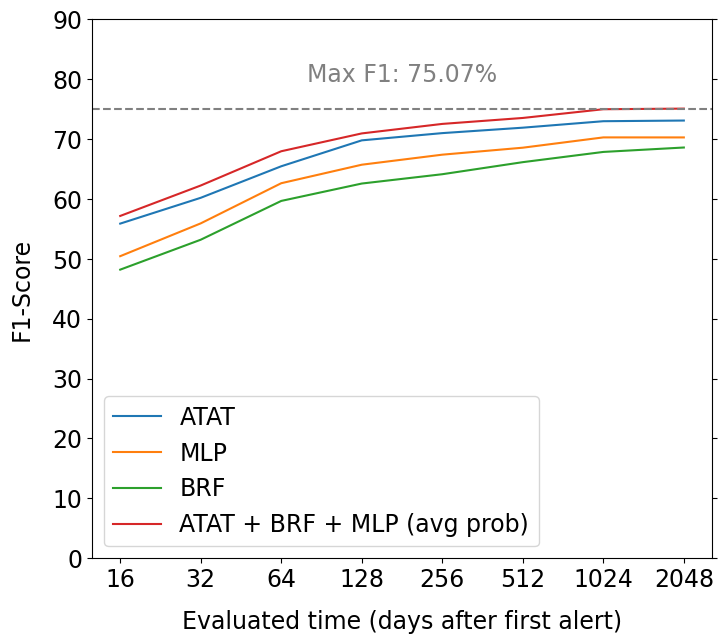

In [341]:
plot_values_times(list_eval_time, models_f1_results_time, max_value)

## ATAT (LC + MD + Features + MTA) 

In [ ]:
with open('final_dataset/dict_classes.json') as f:
   dict_classes = json.load(f)

print(dict_classes)
dict_classes = {v: k for k, v in dict_classes.items()}

#path_exp = 'results_paper/lc/Exp_cfg_-arch=lc_mtime'
path_exp = 'results_paper/lc_tab/Exp_cfg_-arch=lc_header_feat_mtime'
folds = [0, 1, 2, 3, 4]

list_pred_folds = get_y_test_pred_folds(path_exp, dict_classes, folds)

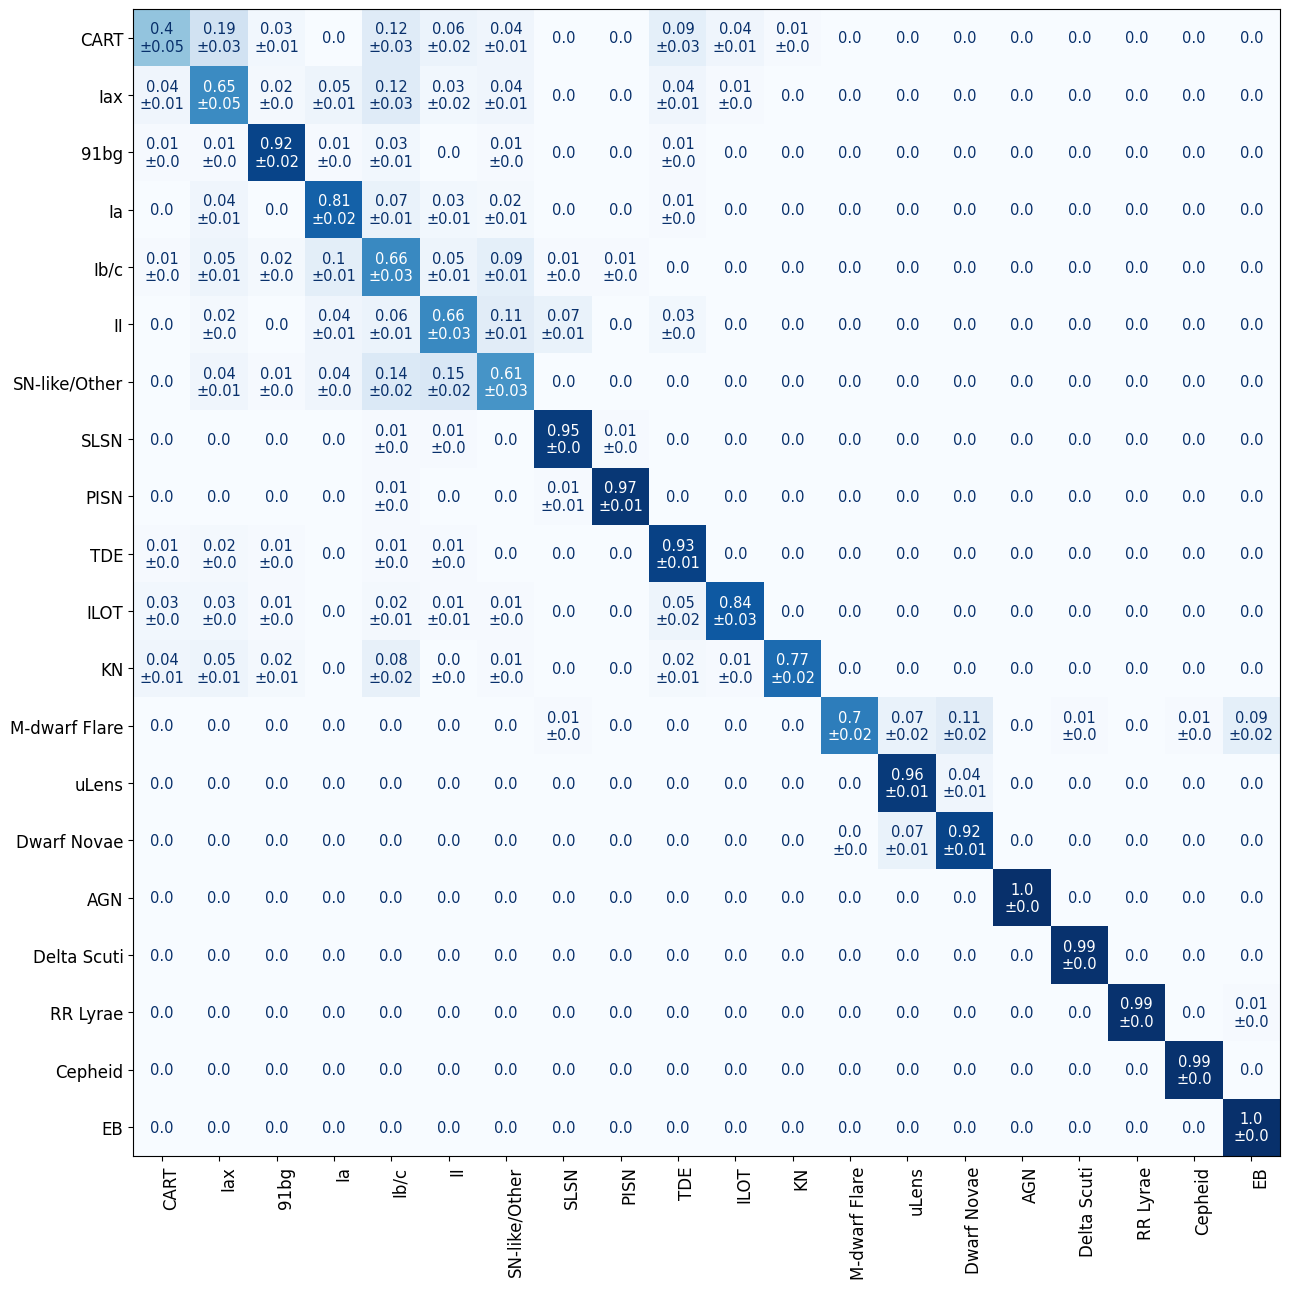

In [49]:
# Suponiendo que tienes y_test_label1, y_pred_label1, y_test_label2, y_pred_label2, etc.
matrices = []
for y_test, y_pred in list_pred_folds:
    cm = confusion_matrix(y_test, y_pred, labels=order_classes, normalize='true')
    matrices.append(cm)

# Calculando la media y la desviación estándar
mean_matrix_lc_md_feat = np.mean(matrices, axis=0)
std_matrix_lc_md_feat = np.std(matrices, axis=0)

get_confusion_matrix(mean_matrix_lc_md_feat, std_matrix_lc_md_feat, order_classes)

## ATAT (LC + MD + MTA) 

In [52]:
#path_exp = 'results_paper/lc/Exp_cfg_-arch=lc_mtime'
path_exp = 'results_paper/lc_tab/Exp_cfg_-arch=lc_header_mtime'
folds = [0, 1, 2, 3, 4]

list_pred_folds = get_y_test_pred_folds(path_exp, dict_classes, folds)

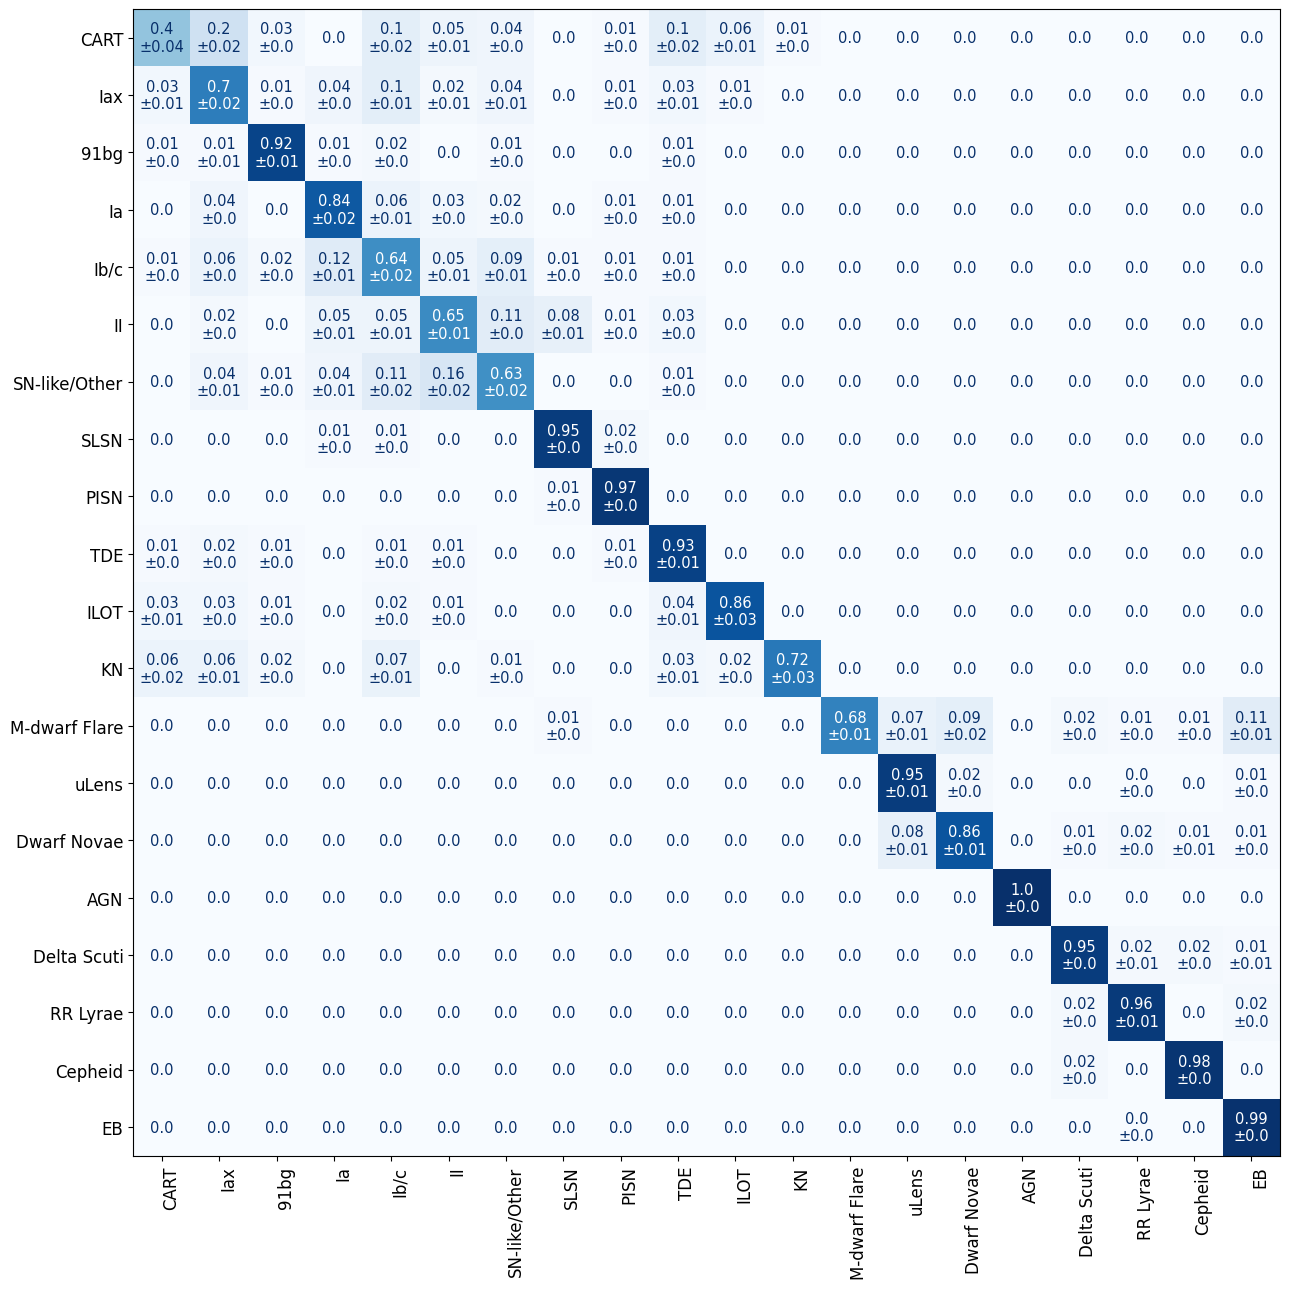

In [53]:
# Suponiendo que tienes y_test_label1, y_pred_label1, y_test_label2, y_pred_label2, etc.
matrices = []
for y_test, y_pred in list_pred_folds:
    cm = confusion_matrix(y_test, y_pred, labels=order_classes, normalize='true')
    matrices.append(cm)

# Calculando la media y la desviación estándar
mean_matrix_lc_md = np.mean(matrices, axis=0)
std_matrix_lc_md = np.std(matrices, axis=0)

get_confusion_matrix(mean_matrix_lc_md, std_matrix_lc_md, order_classes)

## Random Forest

In [54]:
import pandas as pd

path_root = 'results_rf_paper/2048_days'

In [55]:
test_proba_model = []
num_fold = 5

for i_fold in range(num_fold):
    test_proba_model.append(pd.read_parquet('./{}/test_predictions_proba_model_{}.parquet'.format(path_root, i_fold)))

    for idx_row in range(test_proba_model[i_fold].shape[0]):
        idx_col = test_proba_model[i_fold].iloc[idx_row].argmax()
        test_proba_model[i_fold].iloc[idx_row][idx_col] = 1

    test_proba_model[i_fold][test_proba_model[i_fold] != 1] = 0
    test_proba_model[i_fold] = test_proba_model[i_fold][order_classes]

display(test_proba_model[0].head())
display(test_proba_model[1].head())
print(test_proba_model[0].shape)

CART  Iax  91bg   Ia  ...  Delta Scuti  RR Lyrae  Cepheid   EB
SNID                                 ...                                     
63769469_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
66380842_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
64815643_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
52486614_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
34971786_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0

[5 rows x 20 columns]

CART  Iax  91bg   Ia  ...  Delta Scuti  RR Lyrae  Cepheid   EB
SNID                                 ...                                     
63769469_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
66380842_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
64815643_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
52486614_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
34971786_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0

[5 rows x 20 columns]

(20000, 20)


In [56]:
test_set = pd.read_parquet('./data_partition_paper/partitions.parquet')
test_set = test_set[test_set.partition == 'test'].drop(['partition'], axis=1)
test_set['SNID'] = test_set['SNID'].apply(lambda row: row+'_2048')
test_set = test_set.set_index('SNID')
test_set = pd.get_dummies(test_set.label, dtype=float)
test_set = test_set[order_classes]
test_set

CART  Iax  91bg   Ia  ...  Delta Scuti  RR Lyrae  Cepheid   EB
SNID                                 ...                                     
63769469_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
66380842_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
64815643_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
52486614_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
34971786_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
...             ...  ...   ...  ...  ...          ...       ...      ...  ...
34694580_2048   0.0  0.0   0.0  0.0  ...          0.0       0.0      0.0  0.0
42840389_2048   0.0  0.0   0.0  0.0  ...          0.0       0.0      0.0  0.0
28545440_2048   0.0  0.0   0.0  0.0  ...          0.0       0.0      0.0  0.0
19549596_2048   0.0  0.0   0.0  0.0  ...          0.0       0.0      0.0  0.0
52428273_2048   0.0  0.0   0.0  0.0  ...          0.0       0.0      0.0  0.0

[20000 rows x 20 columns]

In [57]:
list_pred_folds = []
for i_fold in folds:
    y_test = np.argmax(test_set.reindex(test_proba_model[i_fold].index).values, axis=1)
    y_pred = np.argmax(test_proba_model[i_fold].values, axis=1)

    y_test_label = [dict_classes[x] for x in y_test]
    y_pred_label = [dict_classes[x] for x in y_pred]

    list_pred_folds.append((y_test_label, y_pred_label))
    

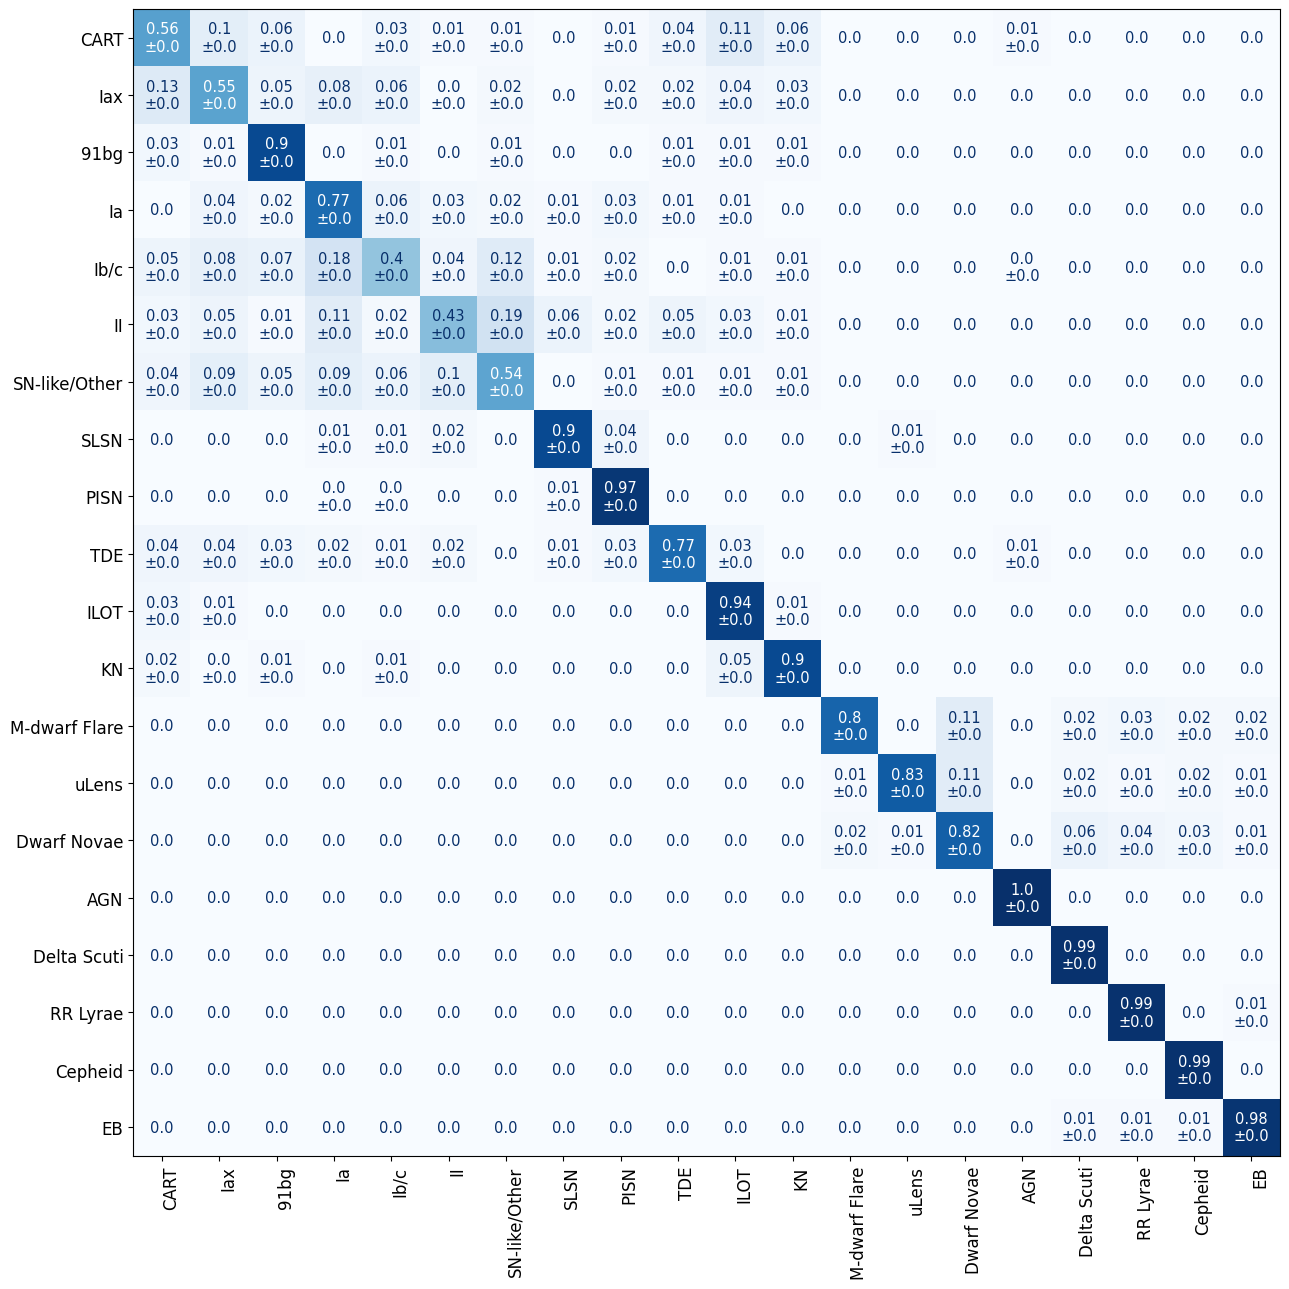

In [58]:
matrices = []
for y_test, y_pred in list_pred_folds:
    cm = confusion_matrix(np.argmax(test_set.reindex(test_proba_model[i_fold].index).values, axis=1), 
                          np.argmax(test_proba_model[i_fold].values, axis=1), 
                          normalize='true')
    #cm = confusion_matrix(test_set.reindex(test_proba_model[i_fold].index).values, test_proba_model[i_fold].values, normalize='pred')
    matrices.append(cm)

# Calculando la media y la desviación estándar
mean_matrix_rf = np.mean(matrices, axis=0)
std_matrix_rf = np.std(matrices, axis=0)

get_confusion_matrix(mean_matrix_rf, std_matrix_rf, order_classes)

## Joint plot

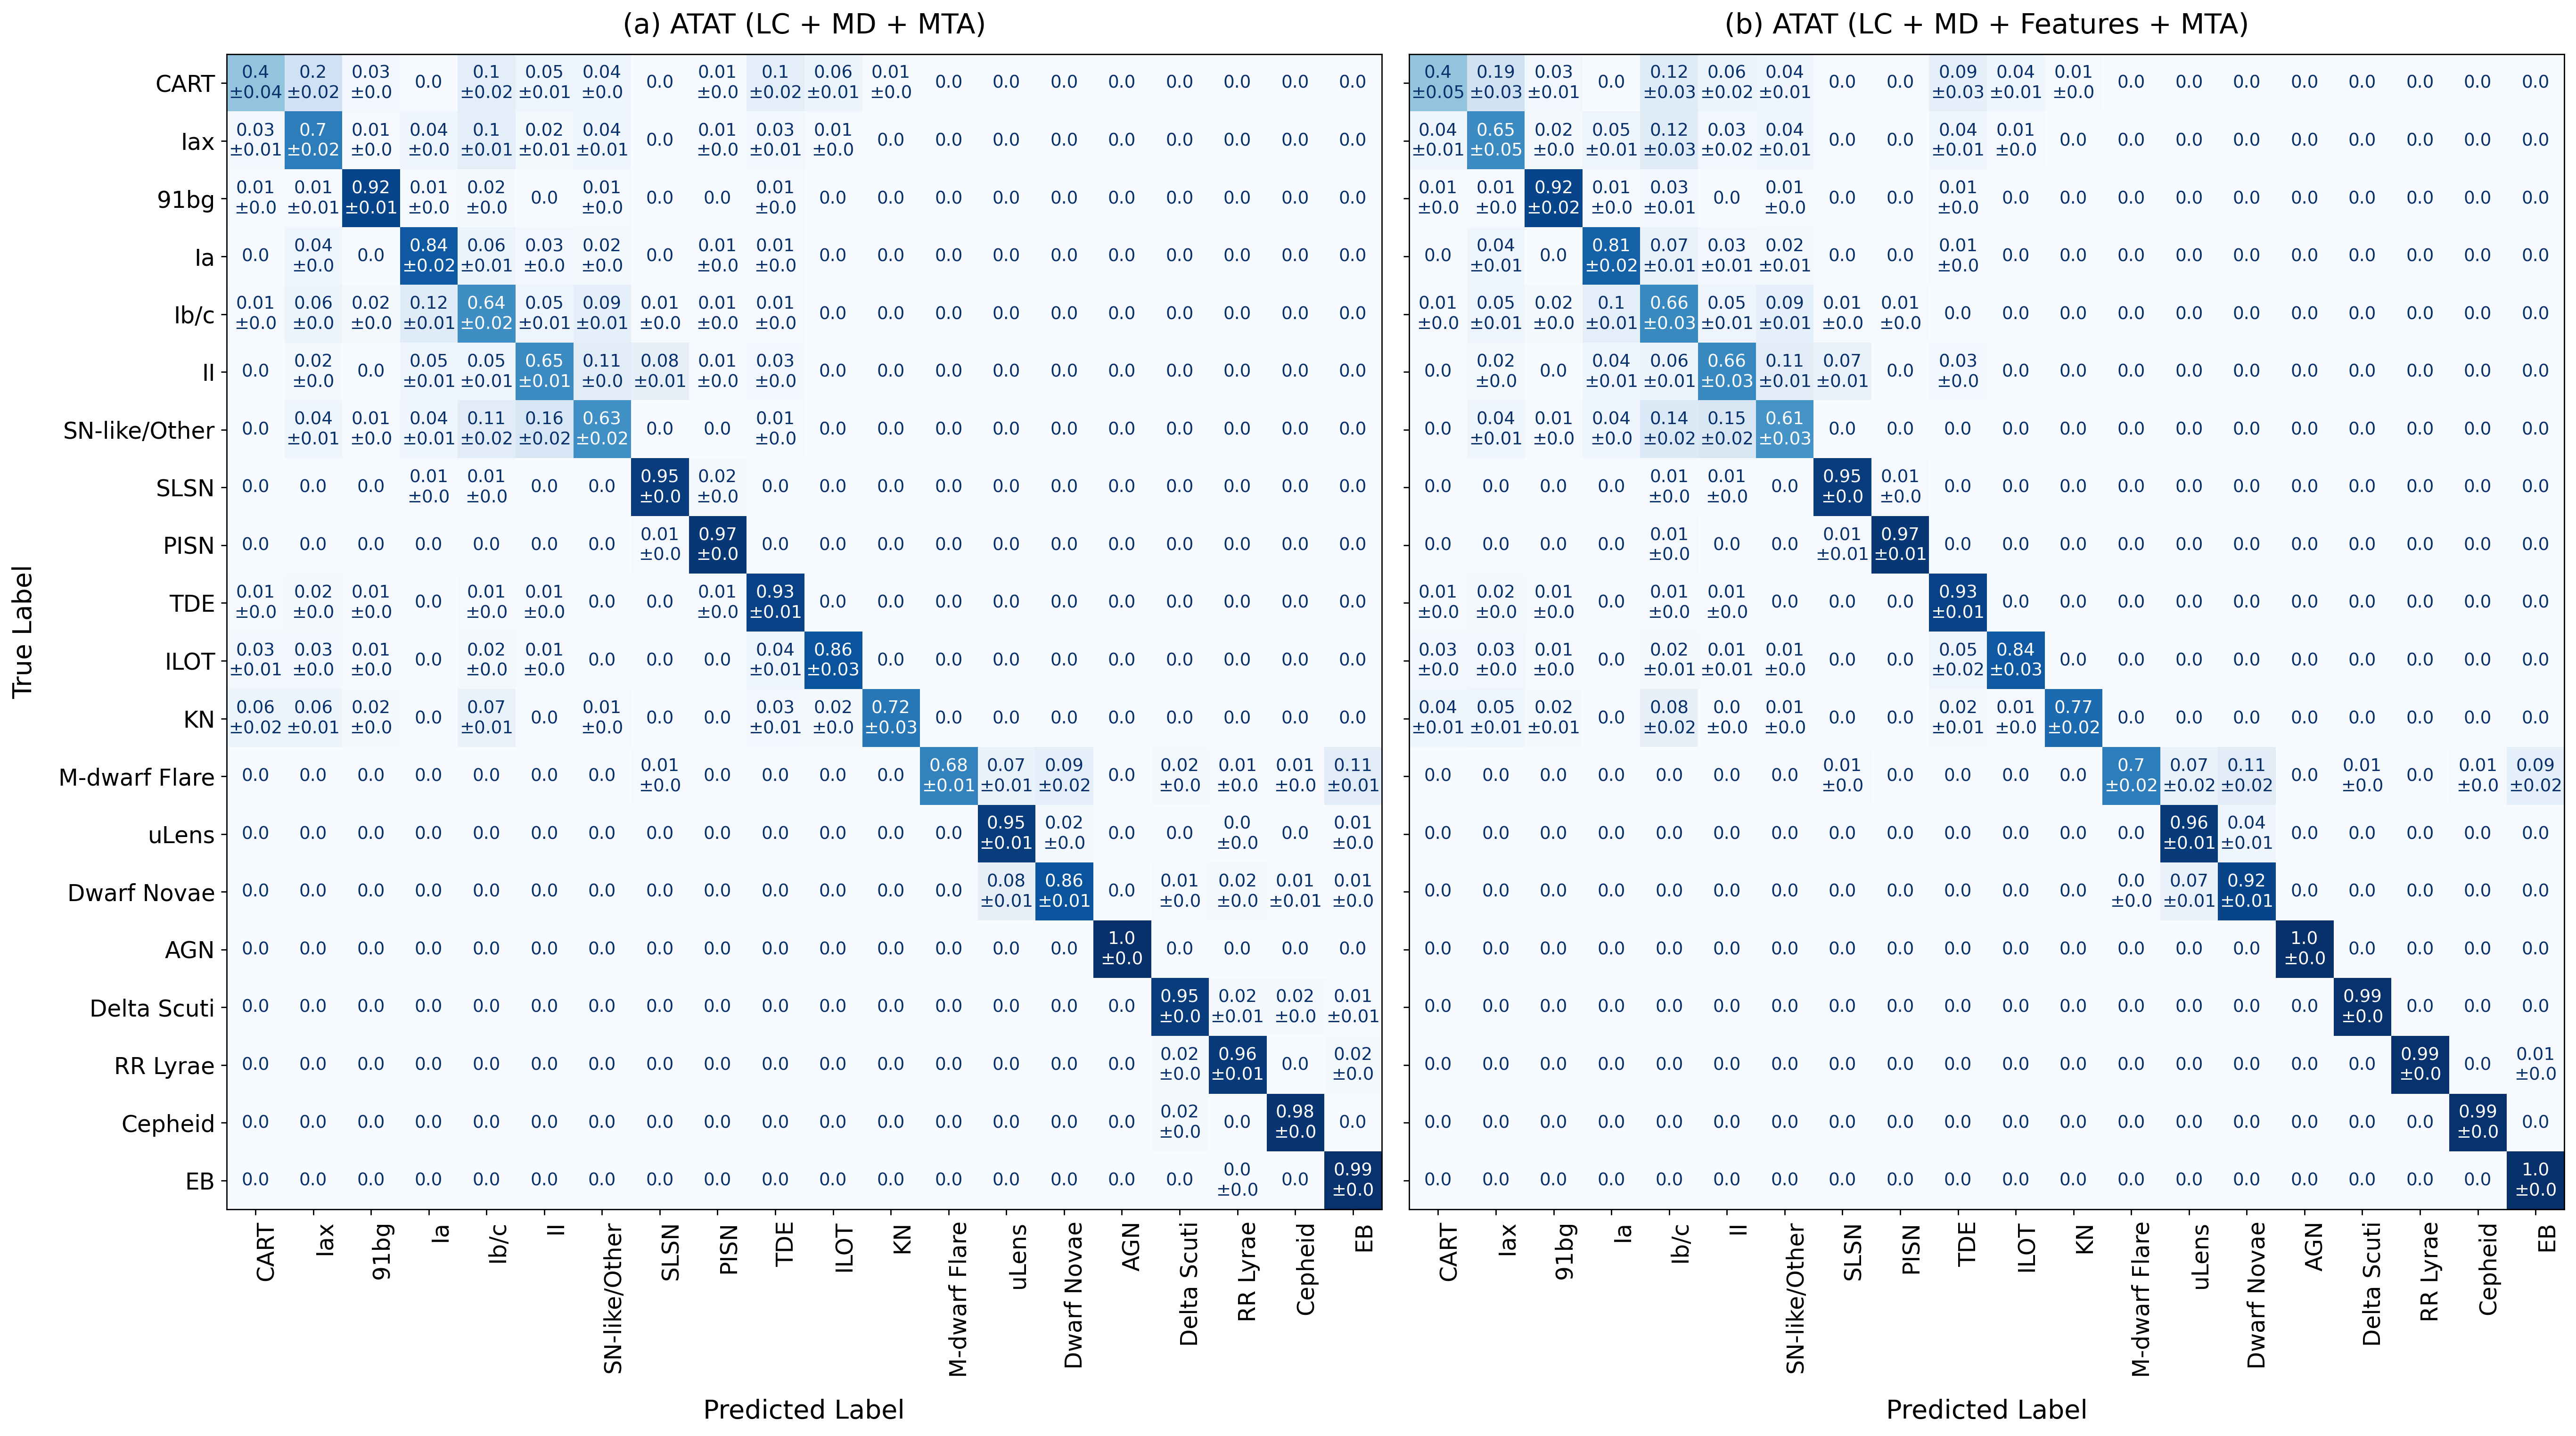

In [89]:
# Graficando la matriz media
cmap = plt.cm.Blues
#fig, ax = plt.subplots(figsize=(13, 13)) #, dpi=110)
fig, axes = plt.subplots(1, 2, figsize=(22, 22), sharey=True, dpi=250)

titles = ['(a) ATAT (LC + MD + MTA)', '(b) ATAT (LC + MD + Features + MTA)']
mean_matrices_col = [mean_matrix_lc_md, mean_matrix_lc_md_feat]
std_matrices_col = [std_matrix_lc_md, std_matrix_lc_md_feat]

for cont, (ax, mean_matrix, std_matrix) in enumerate(zip(axes, mean_matrices_col, std_matrices_col)):
    im = ax.imshow(np.around(mean_matrix, decimals=2), interpolation='nearest', cmap=cmap)

    # color map
    new_color = cmap(1.0) 

    # Añadiendo manualmente las anotaciones con la media y desviación estándar
    for i in range(mean_matrix.shape[0]):
        for j in range(mean_matrix.shape[1]):
            if mean_matrix[i, j] >= 0.005:
                #print(mean_matrix[i, j])
                text = f'{np.around(mean_matrix[i, j], decimals=2)}\n±{np.around(std_matrix[i, j], decimals=2)}'
                color = "white" if mean_matrix[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=10.7)
            else:
                text = f'{np.around(mean_matrix[i, j], decimals=2)}'
                color = "white" if mean_matrix[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=10.7)

    # Ajustes finales y mostrar la gráfica
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xticks(np.arange(len(order_classes)))
    ax.set_yticks(np.arange(len(order_classes)))
    ax.set_xticklabels(order_classes)
    ax.set_yticklabels(order_classes)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.xaxis.labelpad = 13
    ax.yaxis.labelpad = 13

    ax.set_title(titles[cont], fontsize=17, pad=13)
    ax.set_xlabel('Predicted Label', fontsize=16)

    if cont == 0:
        ax.set_ylabel('True Label', fontsize=16)

plt.tight_layout()
#os.makedirs('images', exist_ok=True)
#plt.savefig("./images/cm_ATAT.pdf", format="pdf", bbox_inches="tight")
plt.show()

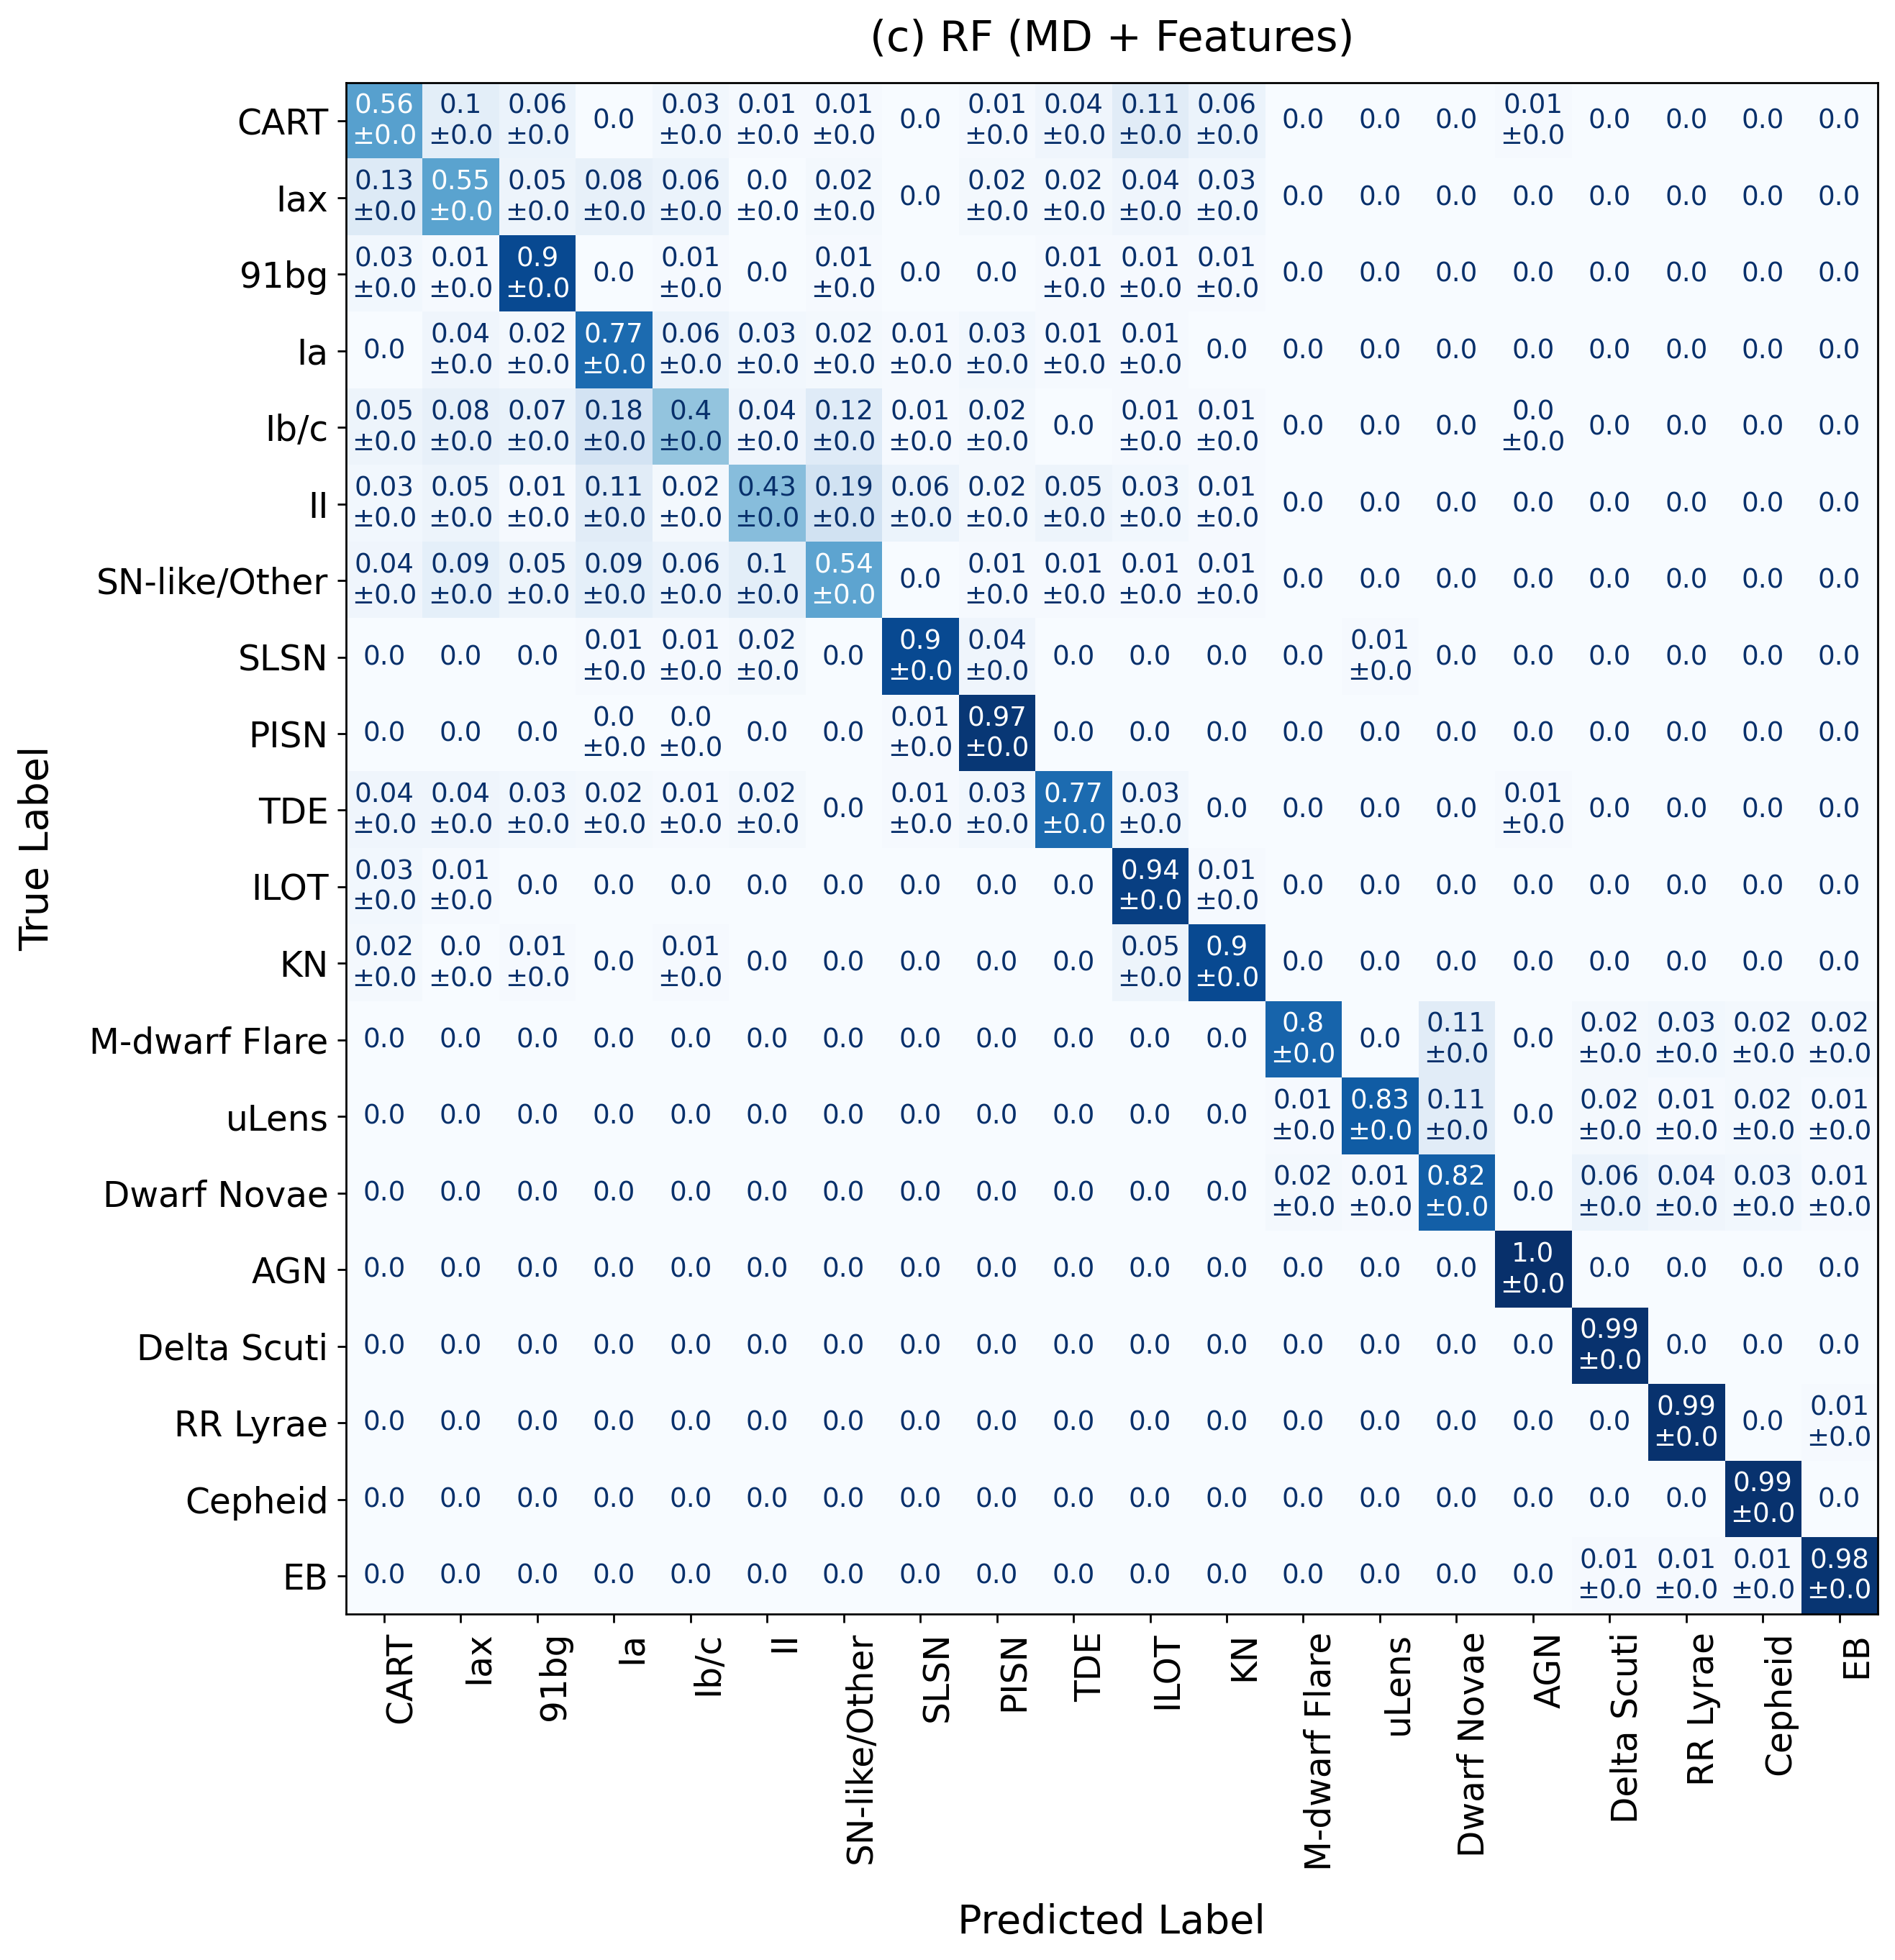

In [90]:
title = '(c) RF (MD + Features)'

# Graficando la matriz media
cmap = plt.cm.Blues
#fig, ax = plt.subplots(figsize=(13, 13)) #, dpi=110)
fig, ax = plt.subplots(1, 1, figsize=(11, 11), sharey=True, dpi=250)

im = ax.imshow(np.around(mean_matrix_rf, decimals=2), interpolation='nearest', cmap=cmap)

# color map
new_color = cmap(1.0) 

# Añadiendo manualmente las anotaciones con la media y desviación estándar
for i in range(mean_matrix_rf.shape[0]):
    for j in range(mean_matrix_rf.shape[1]):
        if mean_matrix_rf[i, j] >= 0.005:
            #print(mean_matrix_rf[i, j])
            text = f'{np.around(mean_matrix_rf[i, j], decimals=2)}\n±{np.around(std_matrix_rf[i, j], decimals=2)}'
            color = "white" if mean_matrix_rf[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=10.7)
        else:
            text = f'{np.around(mean_matrix_rf[i, j], decimals=2)}'
            color = "white" if mean_matrix_rf[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=10.7)

# Ajustes finales y mostrar la gráfica
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks(np.arange(len(order_classes)))
ax.set_yticks(np.arange(len(order_classes)))
ax.set_xticklabels(order_classes)
ax.set_yticklabels(order_classes)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.xaxis.labelpad = 13
ax.yaxis.labelpad = 13

ax.set_title(title, fontsize=17, pad=13)
ax.set_xlabel('Predicted Label', fontsize=16)
ax.set_ylabel('True Label', fontsize=16)

plt.tight_layout()
#os.makedirs('images', exist_ok=True)
#plt.savefig("./images/cm_rf.pdf", format="pdf", bbox_inches="tight")
plt.show()